# The Prithvi-WxC AI Foundation Model for Weather and Climate

This notebook introduces the Prithvi-WxC model and demonstrates how to perform a 12 hour forecasting using unrolling.

In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

## Model input data

The pre-trained Prithvi-WxC model expects as input a dictionary containing three multi-dimensional tensors (data cubes), each representing a different type of information:

- **Dynamic input** (`x`): A 4D tensor of shape $(n_t, n_v, n_{\text{lat}}, n_{\text{lon}})$, where:
  - $n_t = 2$ is the number of input time steps,
  - $n_v = 160$ is the number of dynamic MERRA-2 variables,
  - $n_{\text{lat}} = 360 $ and $n_{\text{lon}} = 576$ are the spatial grid dimensions (latitude and longitude, respectively).

- **Static input** (`static`): A 3D tensor of shape $(n_{v_s}, n_{\text{lat}}, n_{\text{lon}})$, where $n_{v_s} = 10$ is the number of static input variables. These include grid-point positions, the initialization time of the forecast, and static MERRA-2 variables.

- **Climatology** (`climate`): A 3D tensor of shape $(n_v, n_{\text{lat}}, n_{\text{lon}})$ containing the climatological mean values for each dynamic variable at the target lead time.


## Downloading required input data

To be able to perform inference with the Prithvi-WxC model, we first need to download the data required input data. The following data is required to evaluate the model at a given time $t$, input time step $t_i$ and lead time $t_l$:

 - MERRA-2 data from times $t$ and $t - t_i$
 - Static MERRA-2 data for time $t$
 - Climatology data for the time $t + t_l$ 

The ``fm4a`` package provides a helper function to download all required data to perform inference with the Prithvi-WxC model. To use the function you need to make an account with at [NASA EarthData](https://urs.earthdata.nasa.gov/) and [link your](https://urs.earthdata.nasa.gov/approve_app?client_id=e2WVk8Pw6weeLUKZYOxvTQ) account to access the MERRA-2 online archive.

Execute the cell below to download the required input data for a forecasts initialized at August 28, 2021, using a 6-hour time step up to a maximum forecast time of 120 h. The extracted input data for the model will be placed into a folder called ``input_data`` and the downloaded raw data will be stored in a folder ``../data``. 

> **Note**: that the MERRA-2 files are fairly large, so the download will take some time.

     

In [2]:
import numpy as np
from PrithviWxC.download import get_prithvi_wxc_input

initialization_time = np.datetime64("2020-01-01")
get_prithvi_wxc_input(
    initialization_time,
    input_time_step=6, # The time difference in hours between consecutive model input and unrolling steps.
    lead_time=6, # Total maximum lead time.
    input_data_dir="../data/merra-2", # Directory used to store the Prithvi-WxC input data.
    download_dir="../data/raw" # Directory used to store the raw MERRA-2 files.
)

/home/simon/miniforge3/envs/prithvi_precip/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GES DISC username:  pansat123
GES DISC password:  ········


Extracting input data: 100%|█████████████████████████████████████████████████████████████████████████████████| 2/2 [00:27<00:00, 13.94s/it]
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


## The model config

The pre-trained instances of the Prithvi-WxC model that this notebook uses were trained with a specific set of settings. These settings define the exact input variables as well as the size of the model. 


In [37]:
from PrithviWxC.configs import get_model_config
config_name = "large"
prithvi_config = get_model_config(config_name, data_dir="../data")

../data/weights/large


## Loading the data

After downloading the data, we need to load it into memory in the format expected by the Prithvi-WxC model. To do that we use the ``Merra2Dataset`` together with the ``preproc`` function provided by the ``PrithviWxC`` package. 

In [8]:
from PrithviWxC.dataloaders.merra2 import Merra2Dataset, preproc

dataset = Merra2Dataset(
    ("2020-01-01", "2020-01-02"),
    lead_times=[0],
    input_times=[-6],
    data_path_surface="../data/merra-2/",
    data_path_vertical="../data/merra-2/",
    climatology_path_surface="../data/merra-2/climatology/",
    climatology_path_vertical="../data/merra-2/climatology/",
    surface_vars=prithvi_config.surface_vars,
    static_surface_vars=prithvi_config.static_surface_vars,
    vertical_vars=prithvi_config.vertical_vars,
    positional_encoding=prithvi_config.positional_encoding,
    levels=prithvi_config.levels
)
len(dataset)

1

To load a sample from the dataset we can use its, we simply access the sample at the given index. Following this, the ``preproc`` function combines the data into the format expected by the model. The resulting ``input_data`` is a dictionary that contains the three input tensors ``x``, ``static``, and ``climate``. 

In [9]:
input_data = dataset[0]
padding = {"level": (0, 0), "lon": (0, 0), "lat": (0, -1)}
input_data = preproc([input_data], padding=padding)

Below we describe the physical variables that make up the 160 variables included in the ``x`` and ``climate`` inputs and the 10 static variables in the ``static`` input.

### Dynamic input data (``x``)

The dynamic input data (and the ``climatology``) comprises 160 different variables  of which the first 20 correspond to different single-level variables and the latter 140 to 10 profiles of vertically-resolved variables at 14 model levels.
 
#### Single-level variables


The following single-level variables correspond the first twenty values in the dynamic input.


| Input Index | Variable | Full Name                                          | Units                   |
|-------------|----------|----------------------------------------------------|-------------------------|
| 0           | EFLUX    | Total Latent Energy Flux                           | W/m²                    |
| 1           | GWETROOT | Root Zone Soil Wetness                             |  1                      |
| 2           | HFLUX    | Sensible Heat Flux from Turbulence                 | W/m²                    |
| 3           | LAI      | Leaf Area Index                                    | m²/m²                   |
| 4           | LWGAB    | Surface Absorbed Longwave Radiation                | W/m²                    |
| 5           | LWGEM    | Surface Emitted Longwave Radiation                 | W/m²                    |
| 6           | LWTUP    | Top of Atmosphere Upwelling Longwave Radiation     | W/m²                    |
| 7           | PS       | Surface Pressure                                   | Pa                      |
| 8           | QV2M     | Specific Humidity at 2 Meters                      | kg/kg                   |
| 9           | SLP      | Sea Level Pressure                                 | Pa                      |
| 10          | SWGNT    | Surface Net Downward Shortwave Flux                | W/m²                    |
| 11          | SWTNT    | Net Shortwave Downward Flux at TOA                 | W/m²                    |
| 12          | T2M      | Air Temperature at 2 Meters                        | K                       |
| 13          | TQI      | Ice Water Path                                     | kg/m²                   |
| 14          | TQL      | Liquid Water Path                                  | kg/m²                   |
| 15          | TQV      | Total Precipitable Water Vapor                     | kg/m²                   |
| 16          | TS       | Surface Skin Temperature                           | K                       |
| 17          | U10M     | Eastward Wind at 10 Meters                         | m/s                     |
| 18          | V10M     | Northward Wind at 10 Meters                        | m/s                     |
| 19          | Z0M      | Surface Roughness                                  | m                       |

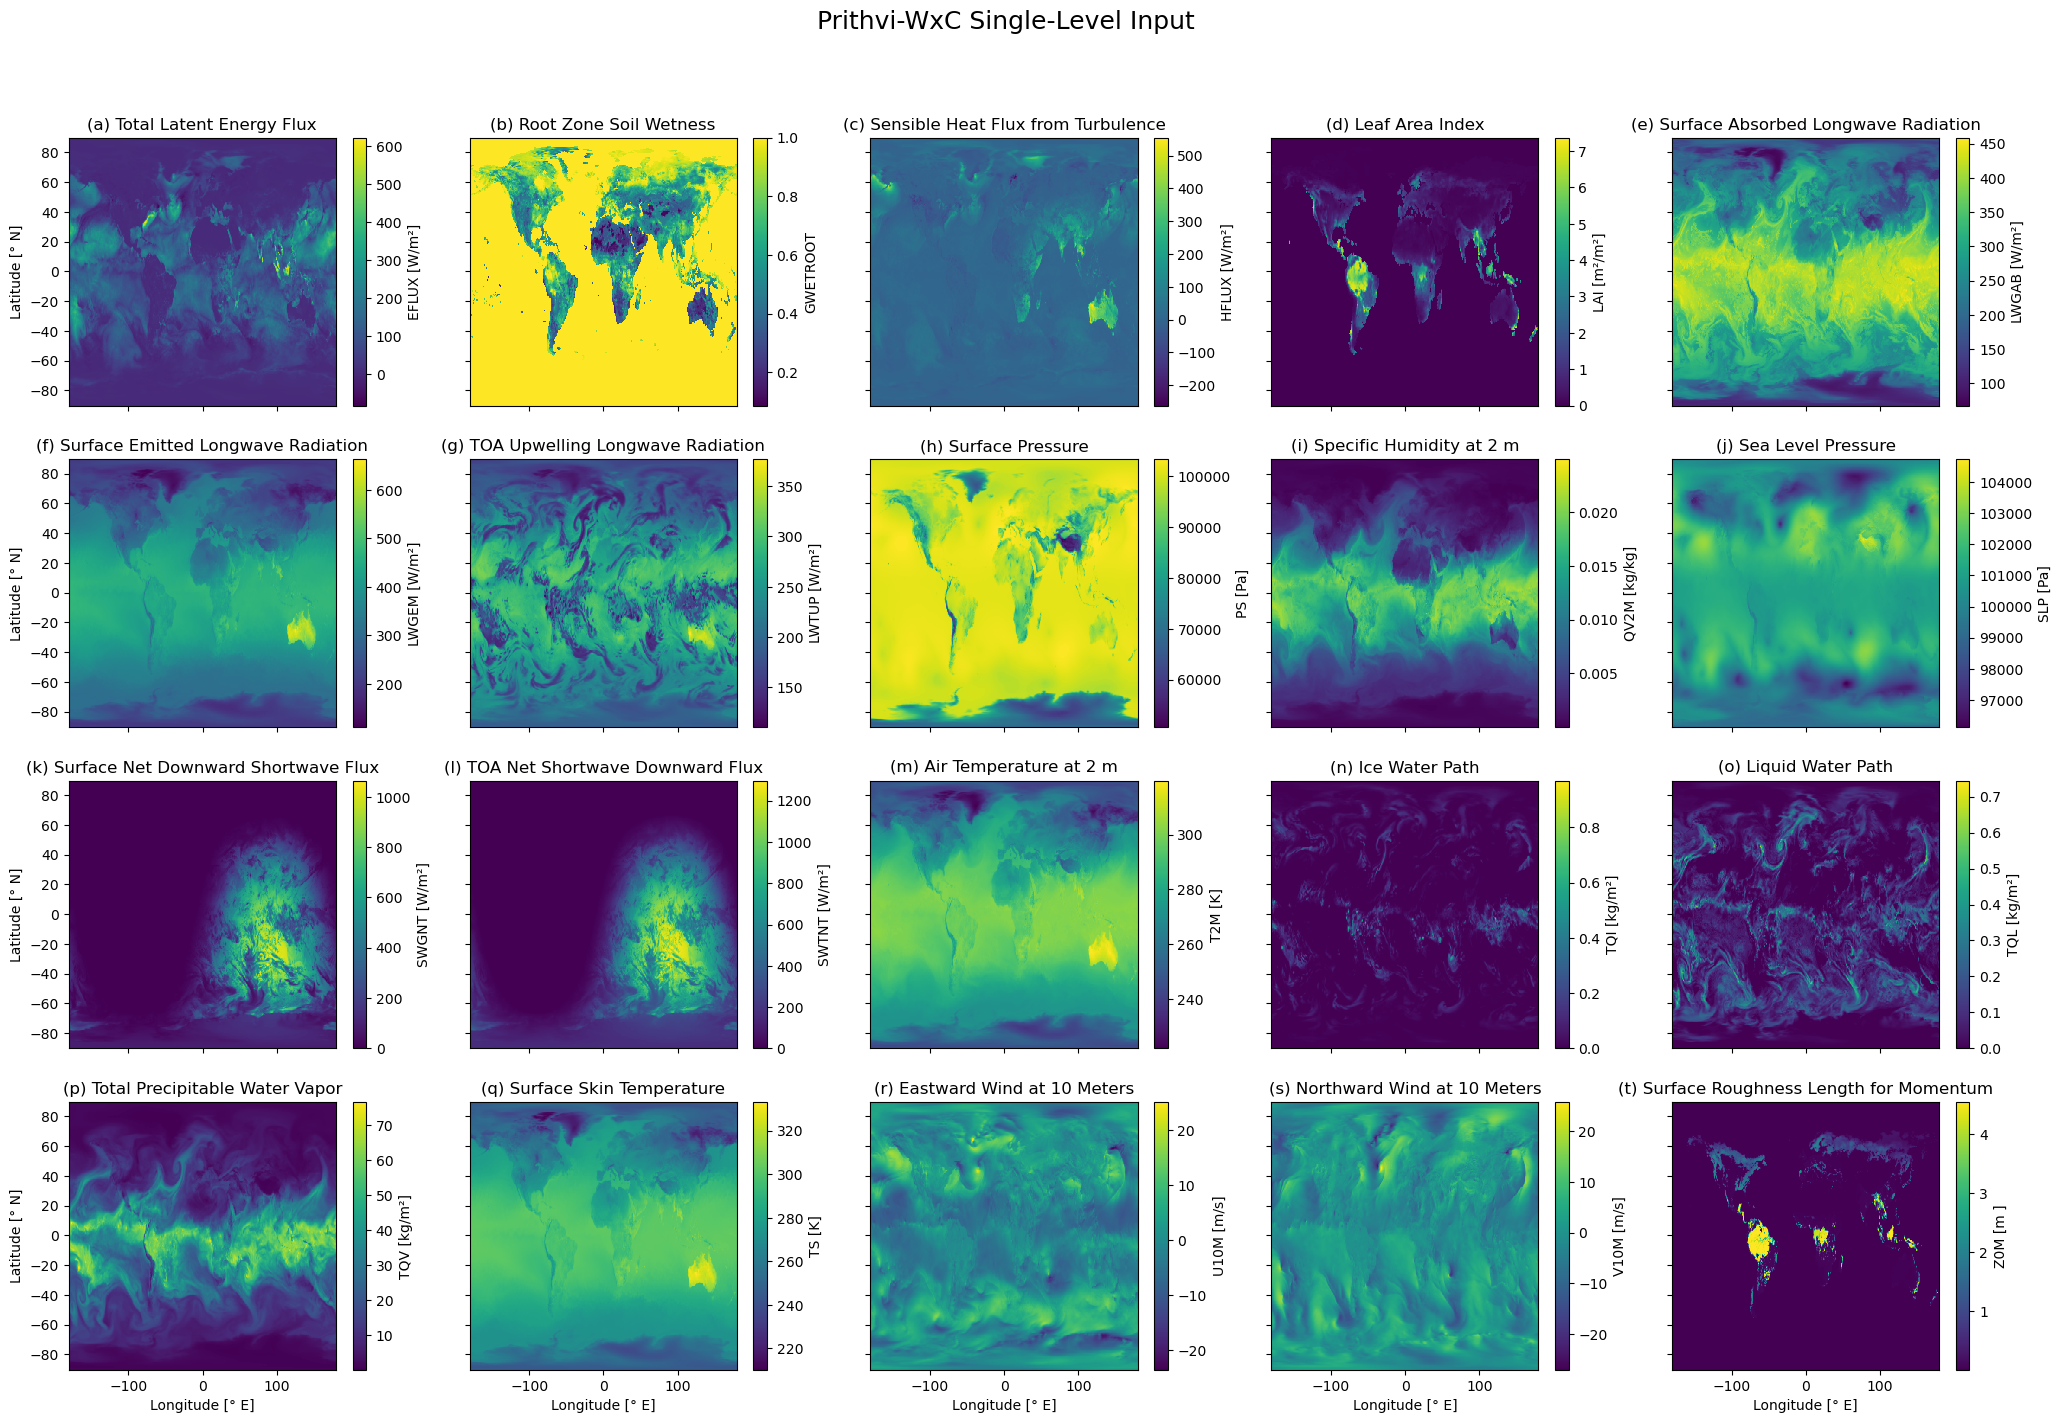

In [10]:
from PrithviWxC.definitions import UNITS, LONG_NAMES
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(25, 16))
gs = GridSpec(4, 5)

lats = np.rad2deg(input_data["static"][0, 0, ..., 0])
lons = np.rad2deg(input_data["static"][0, 1, 0])

for row_ind in range(4):
    for col_ind in range(5):

        var_ind = row_ind * 5 + col_ind
        var_name = prithvi_config.surface_vars[var_ind]
        long_name = LONG_NAMES[var_name]
        unit = UNITS[var_name]
        if unit != "":
            unit = f" [{unit}]"
        
        ax = fig.add_subplot(gs[row_ind, col_ind])
        ax.set_title(f"({chr(ord('a') + var_ind)}) {long_name}")
        
        var = input_data["x"][0, -1, var_ind].numpy()

        m = ax.pcolormesh(lons, lats, var)
        plt.colorbar(m, ax=ax, label=var_name + unit)

        if 0 < col_ind:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel("Latitude [° N]")
            
        if row_ind < 3:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel("Longitude [° E]")

fig.suptitle("Prithvi-WxC Single-Level Input", fontsize=18, y=0.96);

#### Profile variables

The following table lists the vertically-resolved variables that occupy indices 20 - 159 in
the dynamic input. Each profile comprises ten values at the MERRA-2 levels
 [72, 71, 68, 63, 56, 53, 51, 48, 45, 44, 43, 41, 39, 34].

| Input Index Range | Variable | Full Name                              | Units         |
|-------------------|----------|-----------------------------------------|---------------|
| 20-33             | CLOUD    | Cloud Fraction                          | unitless      |
| 34-47             | H        | Geopotential Height                     | m             |
| 48-61             | OMEGA    | Vertical Pressure Velocity              | Pa/s          |
| 62-75             | PL       | Pressure on Model Levels                | Pa            |
| 76-89             | QI       | Ice Water Mixing Ratio                  | kg/kg         |
| 90-103            | QL       | Liquid Water Mixing Ratio               | kg/kg         |
| 104-117           | QV       | Specific Humidity                       | kg/kg         |
| 118-131           | T        | Air Temperature                         | K             |
| 132-145           | U        | Eastward Wind                           | m/s           |
| 146-159           | V        | Northward Wind                          | m/s           |

/tmp/ipykernel_1928238/3220922883.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(prithvi_config.levels[::-1])
/tmp/ipykernel_1928238/3220922883.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(prithvi_config.levels[::-1])


Text(0.5, 0.96, 'Prithvi-WxC Multi-Level Inputs (cross sections along meridian)')

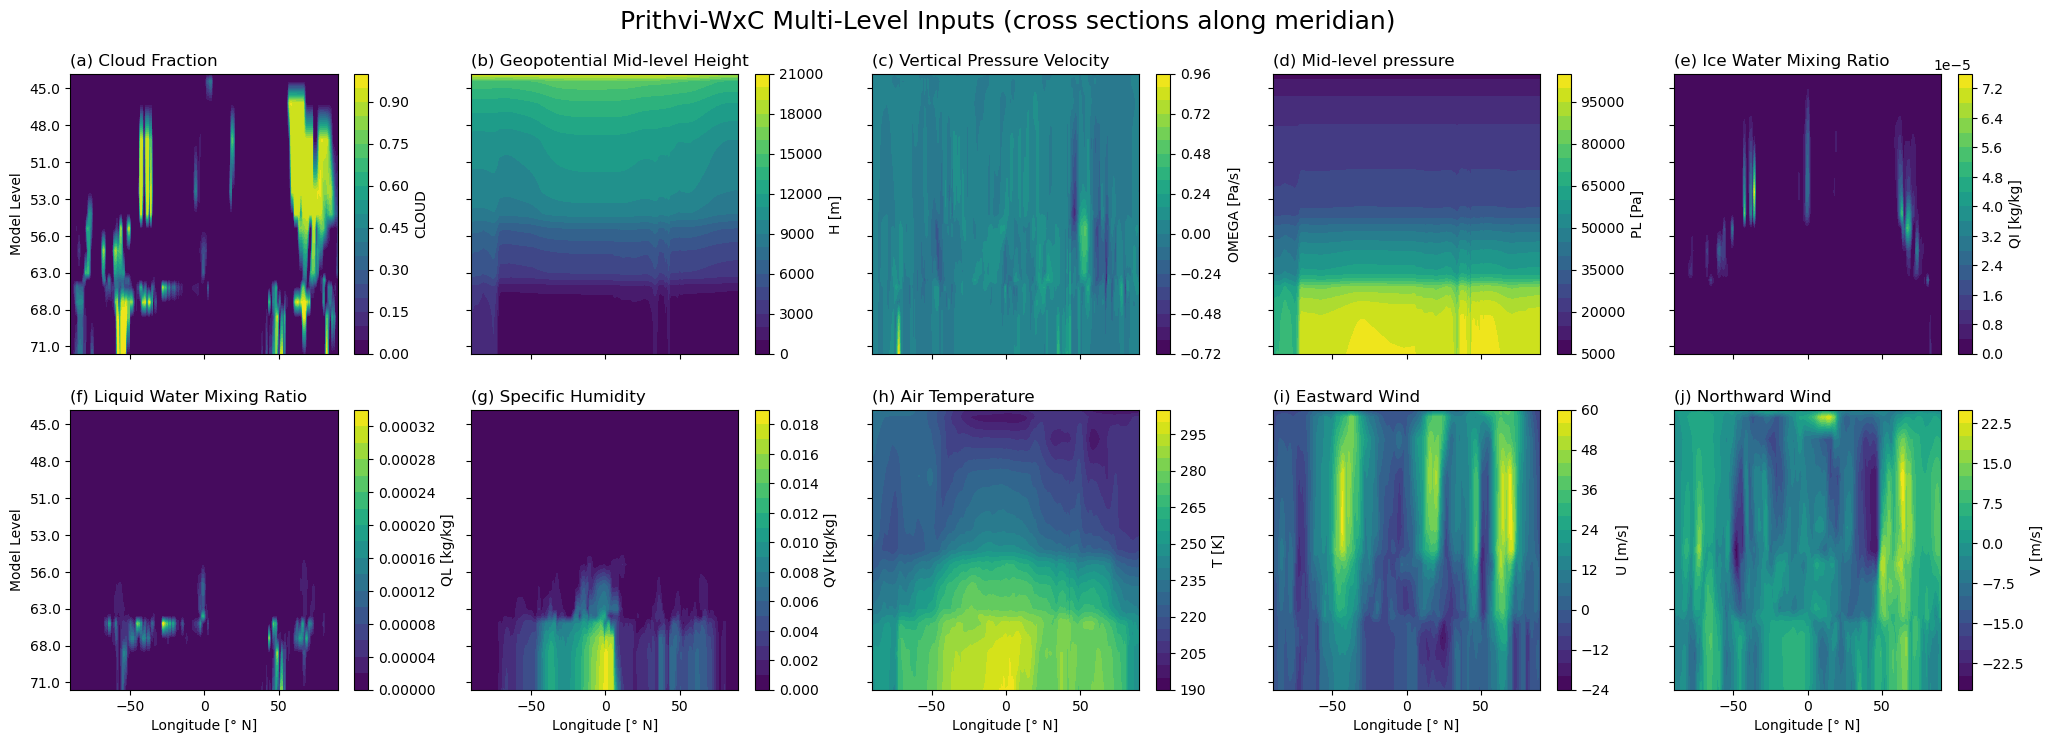

In [11]:
from PrithviWxC.definitions import LONG_NAMES, UNITS
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(25, 8))
gs = GridSpec(2, 5)

lats = np.rad2deg(input_data["static"][0, 0, ..., 0])
lons = np.rad2deg(input_data["static"][0, 1, 0])

for row_ind in range(2):
    for col_ind in range(5):
        
        ax = fig.add_subplot(gs[row_ind, col_ind])
        
        var_ind = (row_ind * 5 + col_ind)
        var_name = prithvi_config.vertical_vars[var_ind]
        long_name = LONG_NAMES[var_name]
        unit = UNITS[var_name]
        if unit != "":
            unit = f" [{unit}]"

        channel_ind = 20 + var_ind * 14
        var = input_data["x"][0, -1, channel_ind: channel_ind + 14, :, 576 // 2].numpy()
        
        ax.set_title(f"({chr(ord('a') + var_ind)}) {long_name}", loc="left")

        m = ax.contourf(lats, prithvi_config.levels[::-1], var, levels=21)
        plt.colorbar(m, ax=ax, label=f"{var_name}{unit}")
        
        if 0 < col_ind:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel("Model Level")
            ax.set_yticklabels(prithvi_config.levels[::-1])
            
        if row_ind < 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel("Longitude [° N]")

fig.suptitle("Prithvi-WxC Multi-Level Inputs (cross sections along meridian)", fontsize=18, y=0.96)

### Static input data

The static input data comprises the following variables:

| Input Index | Variable | Full Name                                   | Units                   |
|-------------|----------|---------------------------------------------|-------------------------|
| 0           |  LAT     | The latitude coordinate of each grid point  | **rad (!)**             |
| 1           |  LON     | The longitude coordinate of each grid point | **rad (!)**             |
| 2           |  DOY     | The sine of the day of the year             |  unitless               |
| 3           |  DOY     | The cosine of the day of the year           |  unitless               |
| 4           |  HOD     | The sine of the hour of the day             |  unitless               |
| 5           |  HOD     | The cosine of the hour of the day           |  unitless               |
| 6           | FRACI    | Sea Ice Fraction                            | unitless                |
| 7           | FRLAND   | Land Fraction                               | unitless                |
| 8           | FROCEAN  | Ocean Fraction                              | unitless                |
| 9           | PHIS     | Surface Geopotential Height                 | m²/s²                   |

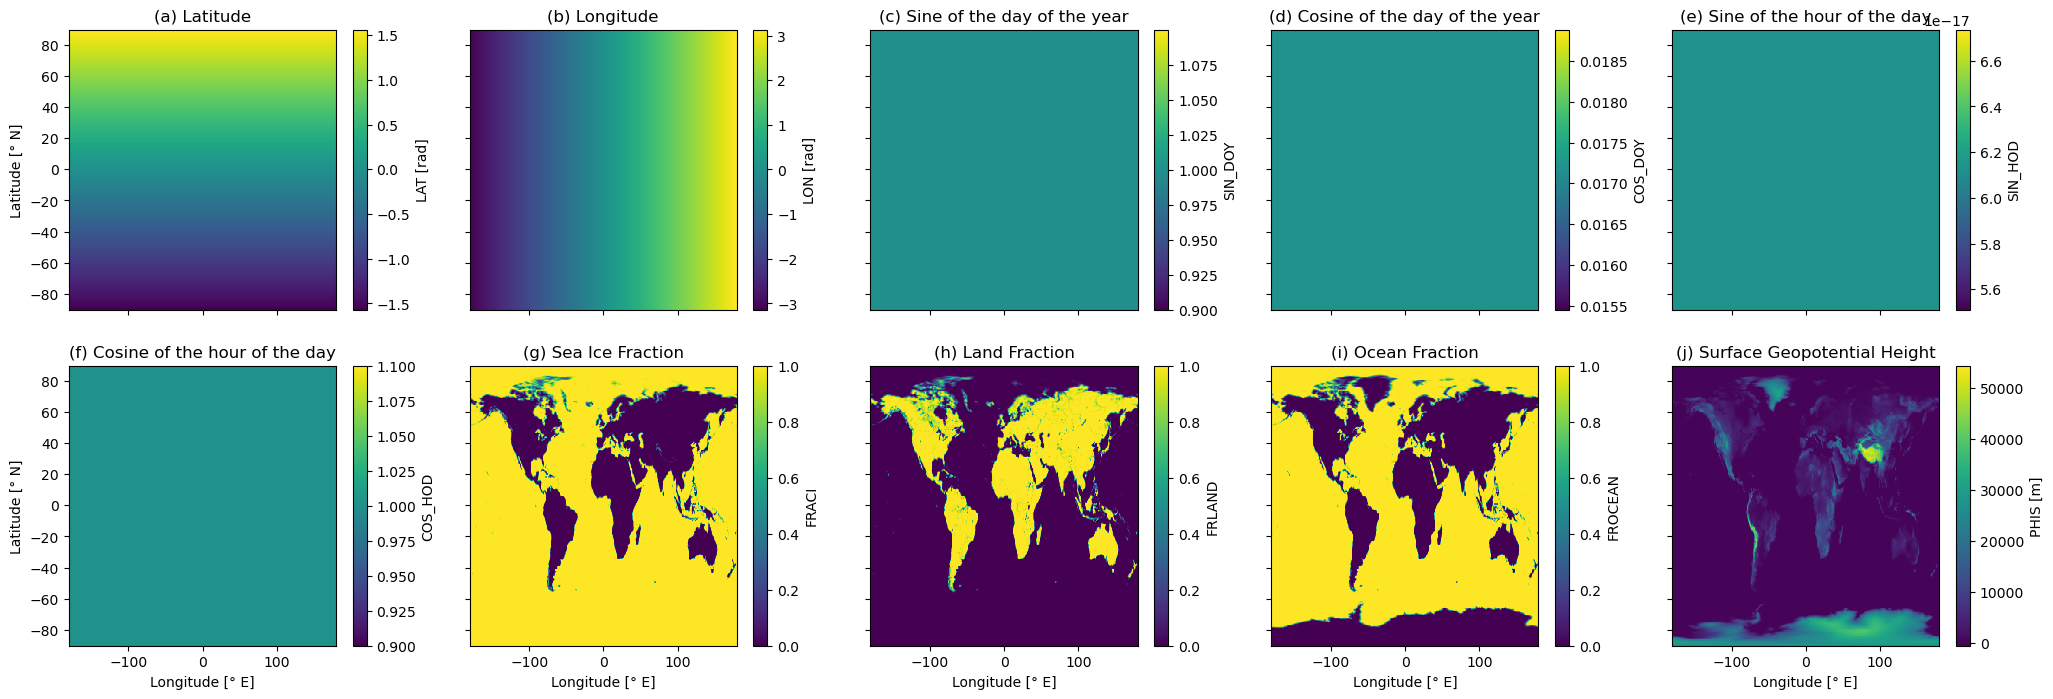

In [12]:
from PrithviWxC.definitions import LONG_NAMES, UNITS
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(25, 8))
gs = GridSpec(2, 5)

lats = np.rad2deg(input_data["static"][0, 0, ..., 0])
lons = np.rad2deg(input_data["static"][0, 1, 0])

for row_ind in range(2):
    for col_ind in range(5):
        
        ax = fig.add_subplot(gs[row_ind, col_ind])
        
        var_ind = row_ind * 5 + col_ind
        var_name = prithvi_config.all_static_vars[var_ind]
        long_name = LONG_NAMES[var_name]
        unit = UNITS[var_name]
        if unit != "":
            unit = f" [{unit}]"
        
        var = input_data["static"][0, var_ind].numpy()

        m = ax.pcolormesh(lons, lats, var)
        plt.colorbar(m, ax=ax, label=f"{var_name}{unit}")
        
        if 0 < col_ind:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel("Latitude [° N]")
            
        if row_ind < 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel("Longitude [° E]")
            
        ax.set_title(f"({chr(ord('a') + var_ind)}) {long_name}")

## The model

In addition to the input data, loading the pre-trained model requires the scaling factors used to normalize the model inputs and the weight resulting from the pretraining.

With the scaling factors and weights downloaded, we can instantiate the model.

In [28]:
import torch
from PrithviWxC.configs import load_model
device = "cuda:1" if torch.cuda.is_available() else "cpu"

model = load_model(
    "small",
    "../data",
    load_weights=True
)
model = model.eval().to(device=device)

## Masked Inference

The Prithvi-WxC model has been pre-trained to predict the atmospheric state defined by the atmospheric state as defined by the 160 at various lead times from masked inputs. Below we use the Prithvi-WxC model to recover the global atmospheric state from a heavily masked input.

In [29]:
batch = {name: tnsr.to(device=device) for name, tnsr in input_data.items()}

In [30]:
import torch
from PrithviWxC.model import masked_inference

global_mask = (np.random.rand(12, 18) > 0.25)
global_mask[7, :] = True

with torch.no_grad():
    pred = masked_inference(model, batch, mask_global=torch.tensor(global_mask).to(device=device))

In [31]:
full_mask = np.repeat(np.repeat(global_mask, 30, -2), 32, -1)

Text(0.5, 0.98, 'Total Precipitable Water Vapor')

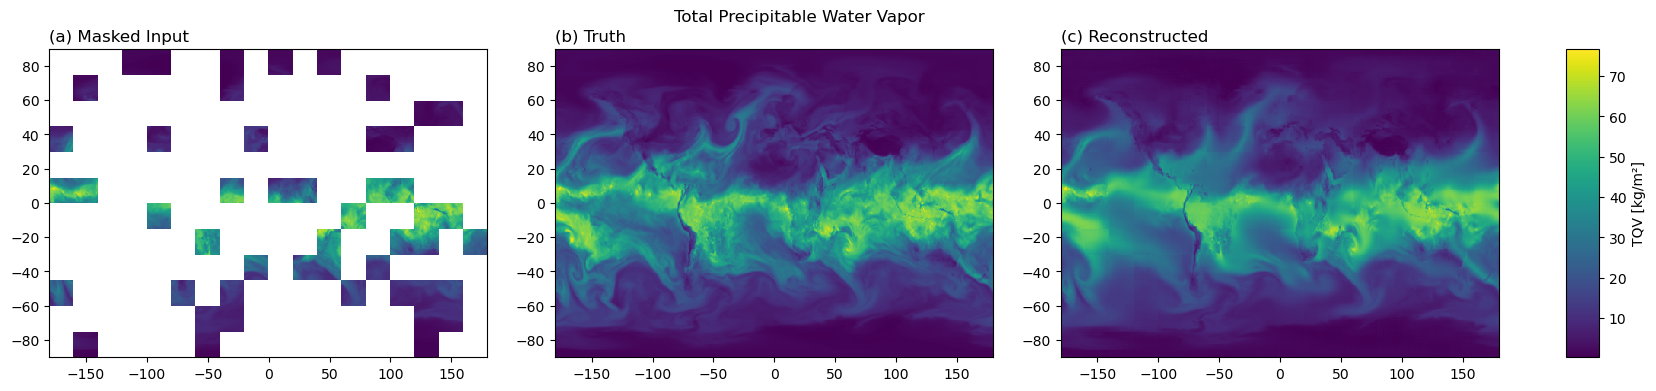

In [32]:
from PrithviWxC.definitions import get_dynamic_variable_name
from matplotlib.gridspec import GridSpec

gs = GridSpec(1, 4, width_ratios=[1.0, 1.0, 1.0, 0.075])
fig = plt.figure(figsize=(20, 4))

lats = np.rad2deg(input_data["static"][0, 0, ..., 0])
lons = np.rad2deg(input_data["static"][0, 1, 0])

var_ind = 15
var_name = get_dynamic_variable_name(prithvi_config, var_ind)
unit = UNITS.get(var_name)
if unit != "":
    unit = f" [{unit}]"
long_name = LONG_NAMES.get(var_name)

inpt = batch["x"][0, 1, var_ind].cpu().numpy()
inpt_masked = inpt.copy()
inpt_masked[..., full_mask] = np.nan
predicted = pred.cpu().numpy()[0, var_ind]

ax = fig.add_subplot(gs[0, 0])
m = ax.pcolormesh(lons, lats, inpt_masked)
ax.set_title("(a) Masked Input", loc="left")

ax = fig.add_subplot(gs[0, 1])
ax.pcolormesh(lons, lats, inpt, norm=m.norm)
ax.set_title("(b) Truth", loc="left")

ax = fig.add_subplot(gs[0, 2])
ax.pcolormesh(lons, lats, predicted, norm=m.norm)
ax.set_title("(c) Reconstructed", loc="left")

cax = fig.add_subplot(gs[0, 3])
plt.colorbar(m, cax=cax, label=f"{var_name}{unit}")

plt.suptitle(long_name)